# Import Library

In [ ]:
!pip install scikit-surprise

In [ ]:
pip install numpy==1.24.3

In [ ]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Recommendation tools
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score

# untuk collaborative filtering)
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy
from surprise.accuracy import rmse, mae

# Lainnya
import warnings
warnings.filterwarnings('ignore')

from google.colab import files

Pada tahap ini, mengimpor semua library Python yang dibutuhkan untuk proses data, visualisasi, dan pembangunan model sistem rekomendasi, baik content-based maupun collaborative filtering.

# Loading Data

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"noviaayufitriana","key":"5acf0065cf29c1efdabfc3ff6ec62661"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d grouplens/movielens-20m-dataset
!unzip -q movielens-20m-dataset.zip -d movielens

Dataset URL: https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset
License(s): unknown
 64% 126M/195M [00:00<00:00, 1.31GB/s]
100% 195M/195M [00:00<00:00, 931MB/s] 


In [ ]:
movies = pd.read_csv('/content/movielens/movie.csv')
ratings = pd.read_csv('/content/movielens/rating.csv', nrows=500_000)

# Tampilkan 5 data teratas
print("Movies head:")
print(movies.head())

print("\nRatings head:")
print(ratings.head())

Movies head:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  

Ratings head:
   userId  movieId  rating            timestamp
0       1        2     3.5  2005-04-02 23:53:47
1       1       29     3.5  2005-04-02 23:31:16
2       1       32     3.5  2005-04-02 23:33:39
3       1       47     3.5  2005-04-02 23:32:07
4       1       50     3.5  2005-04-02 23:29:40


Dataset MovieLens 20M terdiri dari file movies.csv dan ratings.csv. File movies.csv berisi informasi film (movieId, title, genres), sedangkan ratings.csv berisi interaksi user terhadap film (userId, movieId, rating, timestamp).

# Univariate Exploratory Data Analysis

In [ ]:
# Print jumlah data (baris) masing-masing
print(f"\nJumlah data movies: {len(movies)}")
print(f"Jumlah data ratings: {len(ratings)}")


Jumlah data movies: 27278
Jumlah data ratings: 500000


Kode ini berfungsi untuk menampilkan jumlah baris (data) yang ada pada masing-masing dataset movies dan ratings. Dengan kata lain, ini membantu untuk mengetahui berapa banyak data film dan rating yang sudah berhasil dimuat ke dalam program.

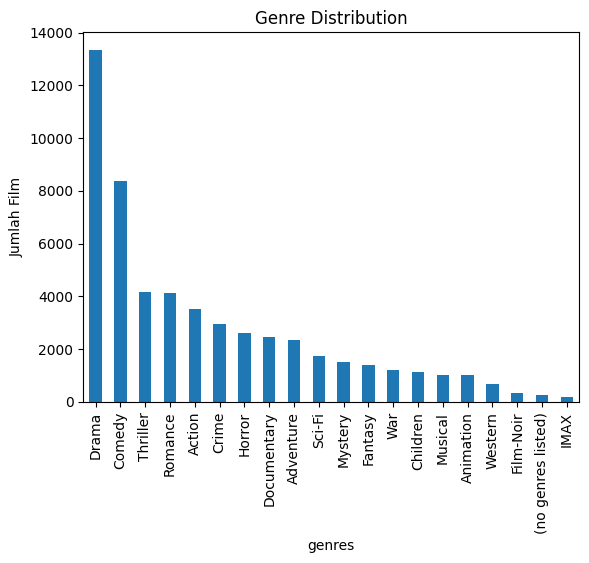

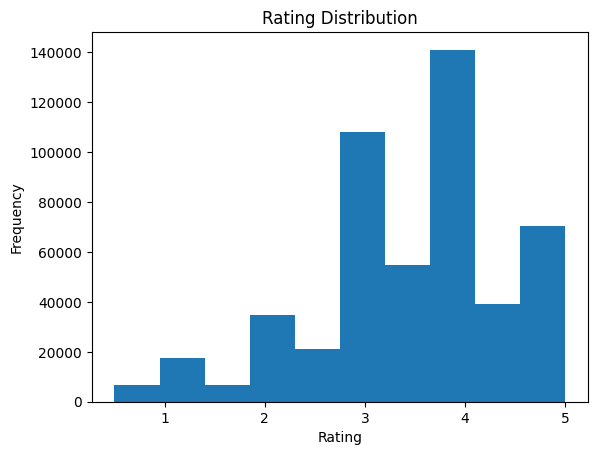

In [ ]:
# Genres
genre_count = movies['genres'].str.split('|').explode().value_counts()
genre_count.plot(kind='bar', title='Genre Distribution')
plt.ylabel('Jumlah Film')
plt.show()

print("\n")
# Ratings
ratings['rating'].plot(kind='hist', bins=10, title='Rating Distribution')
plt.xlabel('Rating')
plt.show()


Di tahap ini kita mengeksplorasi distribusi genre film dan distribusi nilai rating. Ini membantu kita memahami karakteristik data yang akan digunakan dalam model.

# Data Processing

In [ ]:
# Cek missing value
print(movies.isnull().sum())
print("\n")
print(ratings.isnull().sum())

movieId    0
title      0
genres     0
dtype: int64


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Melakukan cek missing value pada dataset movie dan rating

In [ ]:
# Merge ratings dan movies
data = pd.merge(ratings, movies, on='movieId')

Menggabungkan file ratings dengan movies berdasarkan movieId

In [ ]:
# Drop timestamp
data.drop(['timestamp'], axis=1, inplace=True)

Menghapus kolom tidak relevan (timestamp)

In [ ]:
# Hapus duplikat jika ada
data.drop_duplicates(inplace=True)

Membersihkan data duplikat atau tidak berguna.

In [ ]:
# Membersihkan data tanpa genre
movies['genres'] = movies['genres'].replace('(no genres listed)', '')

Sintaks movies ini digunakan untuk membersihkan data pada kolom genres di DataFrame movies dengan mengganti nilai '(no genres listed)' menjadi string kosong. Ini penting agar data tanpa genre tidak mengganggu proses analisis atau pembuatan model content-based seperti TF-IDF, yang mengandalkan teks dalam kolom tersebut.

# Data Preparation

In [ ]:
# TF-IDF untuk Content-Based Filtering
tfidf = TfidfVectorizer(token_pattern=r'[^|]+')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Buat mapping judul ke index
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

Untuk pendekatan Content-Based Filtering, kita menyiapkan TF-IDF berdasarkan genres, dan membuat mapping dari judul ke indeks.

# Modelling Content-Based Filtering

In [ ]:
# Hitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

Baris kode ini digunakan untuk menghitung kemiripan antar film berdasarkan representasi teks (biasanya dari kolom genres, overview, atau gabungan metadata) menggunakan cosine similarity.

In [ ]:
def recommend(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

In [ ]:
recommend('Toy Story (1995)')

,title
2209,Antz (1998)
3027,Toy Story 2 (1999)
3663,"Adventures of Rocky and Bullwinkle, The (2000)"
3922,"Emperor's New Groove, The (2000)"
4790,"Monsters, Inc. (2001)"
10114,DuckTales: The Movie - Treasure of the Lost La...
10987,"Wild, The (2006)"
11871,Shrek the Third (2007)
13337,"Tale of Despereaux, The (2008)"
18274,Asterix and the Vikings (Astérix et les Viking...


Model menghitung kemiripan antar film berdasarkan genre menggunakan TF-IDF dan cosine similarity. Output berupa 10 rekomendasi film yang paling mirip dengan input.

# Modelling Collaborative Filtering

In [ ]:
# Format data untuk Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data_cf = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Split data menjadi train dan test (80% train, 20% test)
trainset, testset = train_test_split(data_cf, test_size=0.2, random_state=42)

# Gunakan model SVD
model = SVD()

# Training model dengan data train
model.fit(trainset)

Kode ini menyiapkan data rating untuk model Collaborative Filtering dengan Surprise, membagi data menjadi train dan test, lalu melatih model SVD menggunakan data train untuk memprediksi preferensi pengguna terhadap film.

In [ ]:
from collections import defaultdict

# Buat prediksi pada data test
predictions = model.test(testset)

# Fungsi untuk mendapatkan top-N rekomendasi per user
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Urutkan setiap user berdasarkan rating prediksi tertinggi
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# Ambil top-10 rekomendasi untuk setiap user
top_n = get_top_n(predictions, n=10)

# tampilkan rekomendasi untuk userId tertentu
for uid, user_ratings in top_n.items():
    if uid == 822:
        print(f"Rekomendasi untuk user {uid}:")
        for i, (movie_id, rating) in enumerate(user_ratings, 1):
            print(f"{i}. MovieID: {movie_id}, Predicted Rating: {rating:.2f}")
        break


Rekomendasi untuk user 822:
1. MovieID: 7153, Predicted Rating: 4.46
2. MovieID: 2959, Predicted Rating: 4.30
3. MovieID: 260, Predicted Rating: 4.20
4. MovieID: 1291, Predicted Rating: 4.08
5. MovieID: 2762, Predicted Rating: 3.96
6. MovieID: 1136, Predicted Rating: 3.94
7. MovieID: 40815, Predicted Rating: 3.90
8. MovieID: 4963, Predicted Rating: 3.88
9. MovieID: 4973, Predicted Rating: 3.81
10. MovieID: 8368, Predicted Rating: 3.80


Kode ini menghasilkan top-10 rekomendasi film untuk setiap pengguna berdasarkan prediksi rating dari model collaborative filtering. Rekomendasi diurutkan dari estimasi rating tertinggi, dan ditampilkan hasilnya untuk user dengan ID tertentu (contoh: user 822)

# Evaluasi

### Content-Based Filtering

In [ ]:
print(recommend('Money Train (1995)'))

143                                        Bad Boys (1995)
1398                                          Metro (1997)
4931                                Another 48 Hrs. (1990)
5529                                         Wasabi (2001)
6895                            Last Boy Scout, The (1991)
10842                                 Business, The (2005)
12974                        Fifth Commandment, The (2008)
22079                               Super Cops, The (1974)
416                           Beverly Hills Cop III (1994)
846      Supercop (Police Story 3: Supercop) (Jing cha ...
Name: title, dtype: object


Evaluasi dilakukan secara kualitatif dengan melihat apakah film-film yang direkomendasikan relevan dengan film input.

In [ ]:
# Tentukan threshold untuk similarity agar dianggap "relevan"
threshold = 0.3

# Fungsi untuk evaluasi Content-Based Filtering
def evaluate_content_based(cosine_sim, top_n=10, threshold=0.3):
    precisions = []
    recalls = []
    f1s = []

    n_movies = cosine_sim.shape[0]

    for idx in range(n_movies):
        # Ground truth biner: film yang similarity-nya >= threshold
        true_labels = (cosine_sim[idx] >= threshold).astype(int)
        true_labels[idx] = 0  # exclude self similarity

        # Prediksi biner: top-N film paling mirip
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        top_n_indices = [i[0] for i in sim_scores[1:top_n+1]]  # exclude self

        pred_labels = np.zeros(n_movies, dtype=int)
        pred_labels[top_n_indices] = 1

        # Hitung metrik
        precision = precision_score(true_labels, pred_labels)
        recall = recall_score(true_labels, pred_labels)
        f1 = f1_score(true_labels, pred_labels)

        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

    print(f'Average Precision: {np.mean(precisions):.4f}')
    print(f'Average Recall: {np.mean(recalls):.4f}')
    print(f'Average F1-Score: {np.mean(f1s):.4f}')


# Jalankan evaluasi
evaluate_content_based(cosine_sim, top_n=10, threshold=0.3)


Average Precision: 0.9775
Average Recall: 0.0018
Average F1-Score: 0.0037


Evaluasi dilakukan dengan menghitung metrik Precision, Recall, dan F1-Score.
Kita menggunakan threshold pada nilai cosine similarity untuk membuat ground truth biner film yang dianggap relevan (mirip).
Selanjutnya, kita bandingkan dengan prediksi biner yang dihasilkan dari top-N rekomendasi untuk menghitung ketiga metrik tersebut secara rata-rata.
Metrik ini membantu menilai seberapa baik model merekomendasikan film yang benar-benar relevan.

### Collaborative Filtering

In [ ]:
# Prediksi rating pada data test
predictions = model.test(testset)

# Hitung metrik evaluasi RMSE dan MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8553
MAE:  0.6533


Model dievaluasi menggunakan metrik RMSE dan MAE untuk mengukur seberapa dekat prediksi rating dengan rating asli pengguna pada data test.

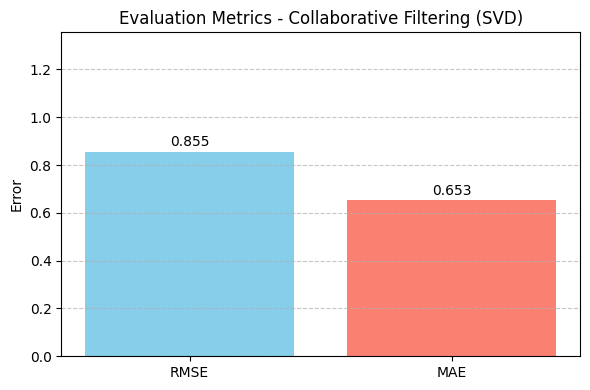

In [ ]:
metrics = ['RMSE', 'MAE']
values = [rmse, mae]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['skyblue', 'salmon'])
plt.title('Evaluation Metrics - Collaborative Filtering (SVD)')
plt.ylabel('Error')

# Tambahkan nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom')

plt.ylim(0, max(values) + 0.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Visualisasi ini menunjukkan performa model SVD berdasarkan metrik RMSE dan MAE. Kedua metrik digunakan untuk mengukur akurasi prediksi rating, di mana nilai yang lebih rendah menunjukkan hasil yang lebih baik.

# inference

menghasilkan rekomendasi Top-N berdasarkan hasil model Collaborative Filtering (SVD) yang sudah dilatih sebelumnya.

In [ ]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

top_n = get_top_n(predictions, n=10)


Fungsi get_top_n mengelompokkan prediksi rating berdasarkan user, lalu mengurutkan dan memilih top-N rekomendasi dengan rating tertinggi untuk setiap user.

In [ ]:
# Menampilkan 2 pengguna pertama saja
for i, (uid, user_ratings) in enumerate(top_n.items()):
    print(f"User {uid} Top-{len(user_ratings)} recommendations:")
    for movie_id, predicted_rating in user_ratings:
        print(f"  MovieID: {movie_id}, Predicted Rating: {predicted_rating:.2f}")
    print("="*40)
    if i == 1:
        break


User 982 Top-10 recommendations:
  MovieID: 1136, Predicted Rating: 4.28
  MovieID: 3307, Predicted Rating: 4.17
  MovieID: 6016, Predicted Rating: 4.14
  MovieID: 1252, Predicted Rating: 4.13
  MovieID: 1089, Predicted Rating: 4.13
  MovieID: 1175, Predicted Rating: 4.12
  MovieID: 1230, Predicted Rating: 4.09
  MovieID: 2966, Predicted Rating: 4.09
  MovieID: 1212, Predicted Rating: 4.07
  MovieID: 6350, Predicted Rating: 4.06
User 515 Top-10 recommendations:
  MovieID: 47, Predicted Rating: 4.66
  MovieID: 150, Predicted Rating: 3.93
  MovieID: 292, Predicted Rating: 3.84
  MovieID: 288, Predicted Rating: 3.78
  MovieID: 588, Predicted Rating: 3.69
  MovieID: 316, Predicted Rating: 3.65
  MovieID: 587, Predicted Rating: 3.60
  MovieID: 597, Predicted Rating: 3.57
  MovieID: 500, Predicted Rating: 3.38
  MovieID: 586, Predicted Rating: 3.36


Menampilkan rekomendasi top-N untuk dua user pertama, mencetak movie ID dan prediksi ratingnya secara singkat.

In [ ]:
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))

# menampilkan rekomendasi lengkap dengan judul film
for uid, user_ratings in top_n.items():
    print(f"User {uid} Top-{len(user_ratings)} recommendations:")
    for movie_id, predicted_rating in user_ratings:
        title = movie_id_to_title.get(movie_id, "Unknown Title")
        print(f"  {title} (MovieID: {movie_id}) - Predicted Rating: {predicted_rating:.2f}")
    print("="*40)
    break


User 982 Top-10 recommendations:
  Monty Python and the Holy Grail (1975) (MovieID: 1136) - Predicted Rating: 4.28
  City Lights (1931) (MovieID: 3307) - Predicted Rating: 4.17
  City of God (Cidade de Deus) (2002) (MovieID: 6016) - Predicted Rating: 4.14
  Chinatown (1974) (MovieID: 1252) - Predicted Rating: 4.13
  Reservoir Dogs (1992) (MovieID: 1089) - Predicted Rating: 4.13
  Delicatessen (1991) (MovieID: 1175) - Predicted Rating: 4.12
  Annie Hall (1977) (MovieID: 1230) - Predicted Rating: 4.09
  Straight Story, The (1999) (MovieID: 2966) - Predicted Rating: 4.09
  Third Man, The (1949) (MovieID: 1212) - Predicted Rating: 4.07
  Laputa: Castle in the Sky (Tenkû no shiro Rapyuta) (1986) (MovieID: 6350) - Predicted Rating: 4.06


Membuat mapping dari movieId ke judul film, lalu menampilkan rekomendasi untuk satu user dengan judul film lengkap beserta prediksi ratingnya.